In [2]:
!pip install tqdm

     |████████████████████████████████| 70 kB 3.5 MB/s eta 0:00:011


In [67]:
# import necessary packages
%matplotlib inline
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import pandas as pd
from tqdm.notebook import tqdm

In [70]:
%matplotlib inline

# Find Neighbors of All Cities

In [232]:
# Load the shape file from github
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape -d shape

In [252]:
# la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes.head()

,slug,set,kind,external_i,name,display_na,sqmi,type,name_1,slug_1,geometry
0,acton,L.A. County Neighborhoods (Current),L.A. County Neighborhood (Current),acton,Acton,Acton L.A. County Neighborhood (Current),39.3391089485,unincorporated-area,None,None,"POLYGON ((-118.20262 34.53899, -118.18947 34.5..."
1,adams-normandie,L.A. County Neighborhoods (Current),L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,Adams-Normandie L.A. County Neighborhood (Curr...,0.805350187789,segment-of-a-city,None,None,"POLYGON ((-118.30901 34.03741, -118.30041 34.0..."
2,agoura-hills,L.A. County Neighborhoods (Current),L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,Agoura Hills L.A. County Neighborhood (Current),8.14676029818,standalone-city,None,None,"POLYGON ((-118.76193 34.16820, -118.72632 34.1..."
3,agua-dulce,L.A. County Neighborhoods (Current),L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,Agua Dulce L.A. County Neighborhood (Current),31.4626319451,unincorporated-area,None,None,"POLYGON ((-118.25468 34.55830, -118.25551 34.5..."
4,alhambra,L.A. County Neighborhoods (Current),L.A. County Neighborhood (Current),alhambra,Alhambra,Alhambra L.A. County Neighborhood (Current),7.62381430605,standalone-city,None,None,"POLYGON ((-118.12175 34.10504, -118.11687 34.1..."


In [235]:
# Graph neighbors of a city
def graph_neighbors(df, index):
    region = df.iloc[index,0]
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)

    temp_n = df.iloc[index,-2].split(',')
    temp_n = [n.strip() for n in temp_n]
    for n in temp_n:
        df.plot_col = df.plot_col.mask(df['region'] == n, 2)
            
    df.plot(column='plot_col', figsize=(10,10))

,region,neighbors
0,Acton,"Agua Dulce, Angeles Crest, Palmdale, Southeast..."
1,Adams-Normandie,"Exposition Park, Harvard Heights, Jefferson Pa..."
2,Agoura Hills,"Calabasas, Unincorporated Santa Monica Mountai..."
3,Agua Dulce,"Acton, Castaic Canyons, Palmdale, Tujunga Canyons"
4,Alhambra,"El Sereno, Monterey Park, San Gabriel, San Mar..."


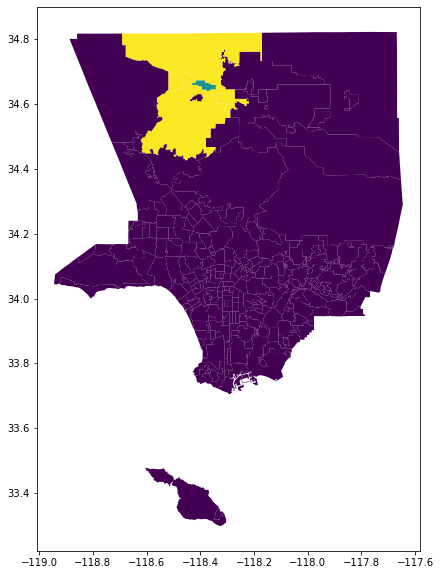

In [236]:
### Get neighbors of every city
la_neighbors = la_shapes.rename(columns={'name':'region'})
la_neighbors["neighbors"] = None  # add NEIGHBORS column
la_neighbors["plot_col"] = 0 # Column used to graph neighbors
la_neighbors = la_neighbors[['region','geometry','neighbors','plot_col']]

for index, row in la_neighbors.iterrows():   
    # Get neighboring cities
    neighbors = la_neighbors[~la_neighbors.geometry.disjoint(row.geometry)].region.tolist()
    # Remove own name from list
    
    if row['region'] in neighbors:
        neighbors.remove(row['region'])
    la_neighbors.at[index, "neighbors"] = ", ".join(neighbors)
# la_neighbors.head()
graph_neighbors(la_neighbors, 70)
la_neighbors = la_neighbors[['region','neighbors']]
la_neighbors.head()

In [244]:
la_neighbors.to_csv('../data/la_neighbors.csv')

# Aggregate Covid Data

In [237]:
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/ANRGUSC/lacounty_covid19_data/master/data/Covid-19.csv
covid_filename = '../data/Covid-19.csv'

covid_df = pd.read_csv(covid_filename)
covid_df.head()

,Time Stamp,Region,Latitude,Longitude,Number of cases
0,03-16-2020,Alhambra,34.093042,-118.127060,2
1,03-16-2020,Arcadia,34.136208,-118.040150,1
2,03-16-2020,Beverly Hills,34.069650,-118.396306,1
3,03-16-2020,Boyle Heights,34.043689,-118.209768,5
4,03-16-2020,Carson,33.832204,-118.251755,1


In [165]:
covid_df[covid_df['Region']=='Alhambra'].head(5)

,Time Stamp,Region,Latitude,Longitude,Number of cases
0,03-16-2020,Alhambra,34.093042,-118.12706,2
31,03-17-2020,Alhambra,34.093042,-118.12706,1
73,03-18-2020,Alhambra,34.093042,-118.12706,1
118,03-19-2020,Alhambra,34.093042,-118.12706,2
188,03-20-2020,Alhambra,34.093042,-118.12706,3


In [193]:
covid_df2 = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df2['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df2 = covid_df2.set_index('Time Stamp')
covid_df2.groupby([pd.Grouper(freq='M'), 'Region']).sum()
covid_df2.index = covid_df2.index.month
covid_df2 = covid_df2.reset_index().rename(columns={'Time Stamp': 'month', 'Region':'region', 'Number of cases':'cases'})
covid_df2

<ipython-input-193-4917ef4088f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df2['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


,month,region,cases
0,3,Alhambra,2
1,3,Arcadia,1
2,3,Beverly Hills,1
3,3,Boyle Heights,5
4,3,Carson,1
...,...,...,...
47627,10,Willowbrook,247
47628,10,Wilmington,1827
47629,10,Wilshire Center,1138
47630,10,Winnetka,1309


### Check for missing cities

In [242]:
check_df = la_neighbors.assign(InDf2=la_neighbors.region.isin(covid_df2.region))
pd.unique(check_df[check_df['InDf2']==False]['region'])

array(['Agua Dulce', 'Alondra Park', 'Angeles Crest', 'Arlington Heights',
       'Avocado Heights', 'Baldwin Hills/Crenshaw', 'Bel-Air',
       'Beverly Grove', 'Broadway-Manchester', 'Castaic Canyons',
       'Central-Alameda', 'Charter Oak', 'Chatsworth Reservoir',
       'Chesterfield Square', 'Citrus', 'Cypress Park', 'Del Aire',
       'Desert View Highlands', 'East Compton', 'East La Mirada',
       'East Pasadena', 'East San Gabriel', 'Elizabeth Lake', 'Fairfax',
       'Gramercy Park', 'Green Valley', 'Griffith Park', 'Hansen Dam',
       'Hasley Canyon', 'Historic South-Central', 'Hollywood Hills West',
       'La Crescenta-Montrose', 'Ladera Heights', 'Lake Hughes',
       'Lake View Terrace', 'Larchmont', 'Lennox', 'Leona Valley',
       'Littlerock', 'Long Beach', 'Lopez/Kagel Canyons',
       'Marina del Rey', 'Mayflower Village', 'Mid-City', 'Mid-Wilshire',
       'Montecito Heights', 'Mount Washington',
       'Northeast Antelope Valley', 'North El Monte',
       'North

In [243]:
check_df = covid_df2.assign(InDf2=covid_df2.region.isin(la_neighbors.region))
pd.unique(check_df[check_df['InDf2']==False]['region'])

array(['City', 'Melrose', 'Silverlake', 'West Vernon', 'Baldwin Hills',
       'Century Palms/Cove', 'Crestview', 'Park LaBrea',
       'Santa Monica Mountains', 'Miracle Mile', 'Park La Brea',
       'Vernon Central', 'Temple', 'Wilshire Center', 'Canyon Country',
       'Pico', 'Wholesale District', 'Crenshaw District',
       'Little Bangladesh', 'Alsace', 'Angelino Heights', 'Bassett',
       'Bel Air', 'Brookside', 'Cadillac-Corning', 'Central',
       'Country Club Park', 'Exposition', 'Faircrest Heights',
       'Figueroa Park Square', 'Gramercy Place', 'Harbor Pines',
       'Lafayette Square', 'Lakeview Terrace', 'Little Armenia',
       'Little Tokyo', 'Longwood', 'Mandeville Canyon',
       'Marina Peninsula', 'Mid-city', 'Palisades Highlands',
       'Playa Del Rey', 'Regent Square', 'Reseda Ranch',
       'Reynier Village', 'South Carthay', 'St Elmo Village',
       'Sycamore Square', 'Temple-Beaudry', 'Thai Town', 'Toluca Terrace',
       'Toluca Woods', 'University Hills